Cumulative variance explained by 50 components: 0.50


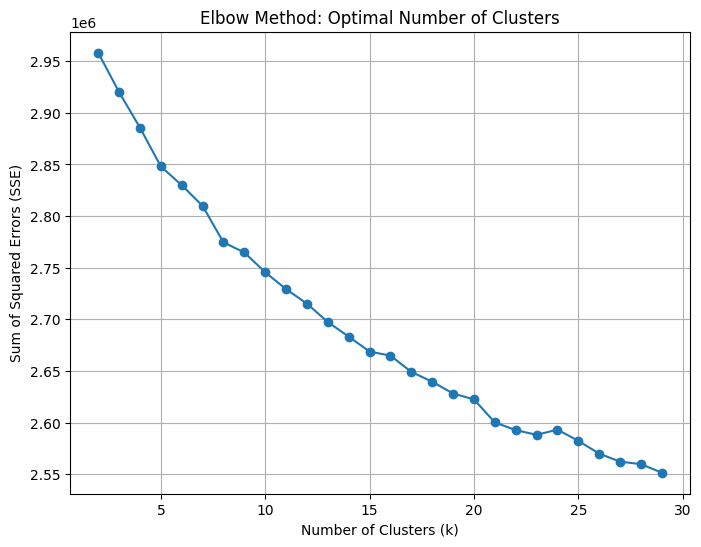

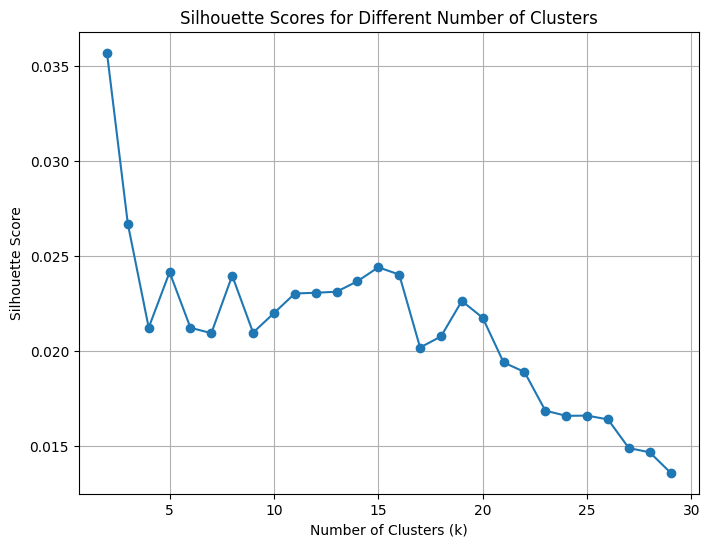

Davies-Bouldin Index: 4.95
Calinski-Harabasz Index: 13.08
Cluster sizes:
8    134
1    125
2    124
0    122
4    107
7     90
6     88
9     80
3     68
5     62
Name: count, dtype: int64
Number of clusters found by DBSCAN: 0


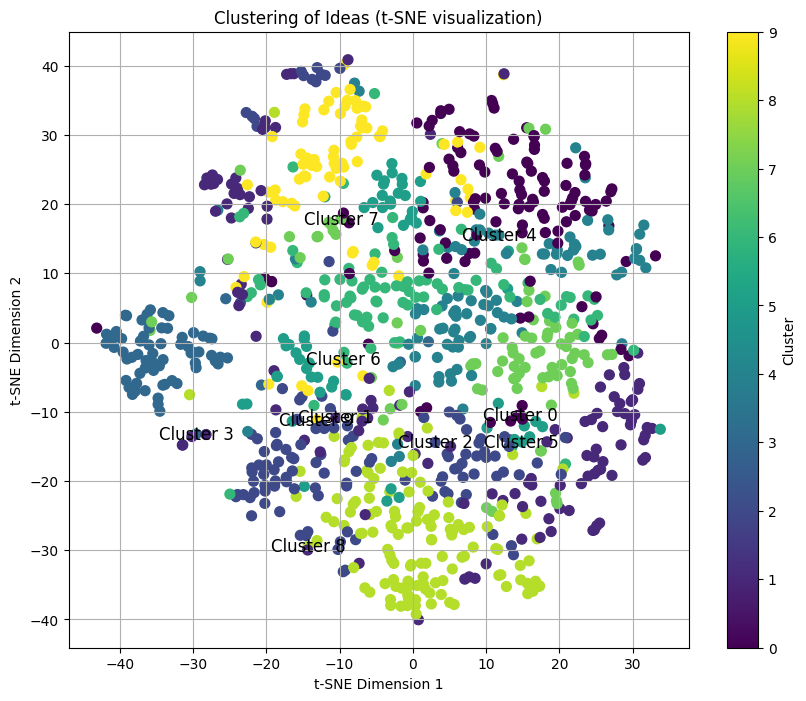

Cluster 0 saved to /Users/alexthorpe/Desktop/cluster_files/cluster_0.csv
Cluster 1 saved to /Users/alexthorpe/Desktop/cluster_files/cluster_1.csv
Cluster 2 saved to /Users/alexthorpe/Desktop/cluster_files/cluster_2.csv
Cluster 3 saved to /Users/alexthorpe/Desktop/cluster_files/cluster_3.csv
Cluster 4 saved to /Users/alexthorpe/Desktop/cluster_files/cluster_4.csv
Cluster 5 saved to /Users/alexthorpe/Desktop/cluster_files/cluster_5.csv
Cluster 6 saved to /Users/alexthorpe/Desktop/cluster_files/cluster_6.csv
Cluster 7 saved to /Users/alexthorpe/Desktop/cluster_files/cluster_7.csv
Cluster 8 saved to /Users/alexthorpe/Desktop/cluster_files/cluster_8.csv
Cluster 9 saved to /Users/alexthorpe/Desktop/cluster_files/cluster_9.csv


In [18]:
import os
import json
from dotenv import load_dotenv
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
from pinecone.grpc import PineconeGRPC as Pinecone

# Load environment variables
load_dotenv()

# Set up Pinecone API key and initialize
pinecone_api_key = os.getenv("PINECONE_API_KEY")
if not pinecone_api_key:
    raise ValueError("PINECONE_API_KEY is not set in the .env file")

pc = Pinecone(api_key=pinecone_api_key)

index_name = 'idea-index'
namespace = os.getenv("PINECONE_NAMESPACE")
index = pc.Index(index_name)

# Use the describe_index_stats method to get metadata including total vectors
stats = index.describe_index_stats()
vector_count = stats["total_vector_count"]

all_ids = []

for ids in index.list(namespace=namespace):
    all_ids.extend(ids)

embeddings = []

# Step 1: Fetch embeddings in batches
batch_size = 500

for i in range(0, len(all_ids), batch_size):
    batch_ids = all_ids[i:i + batch_size]
    response = index.fetch(ids=batch_ids, namespace=namespace)
    embeddings.extend([vector["values"] for vector in response["vectors"].values()])

# Convert embeddings to a NumPy array
embeddings = np.array(embeddings, dtype=np.float32)

# Step 2: Dimensionality reduction
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(embeddings)

# Use PCA for initial reduction to 50 dimensions
pca = PCA(n_components=50)
reduced_embeddings = pca.fit_transform(scaled_embeddings)

# Check variance explained by PCA components
explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"Cumulative variance explained by 50 components: {explained_variance:.2f}")

# Use t-SNE for final 2D visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(reduced_embeddings)

# Step 3: Determine optimal number of clusters using Elbow Method
sse = []
k_values = range(2, 30)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_embeddings)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(k_values, sse, marker='o')
plt.title("Elbow Method: Optimal Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Sum of Squared Errors (SSE)")
plt.grid(True)
plt.show()

# Step 4: Determine optimal clusters using Silhouette Score
silhouette_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_embeddings)
    score = silhouette_score(scaled_embeddings, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title("Silhouette Scores for Different Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

# Step 5: Use K-Means clustering with the chosen number of clusters
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(scaled_embeddings)

# Additional Metrics to evaluate clustering quality
davies_bouldin = davies_bouldin_score(scaled_embeddings, labels)
calinski_harabasz = calinski_harabasz_score(scaled_embeddings, labels)
print(f"Davies-Bouldin Index: {davies_bouldin:.2f}")  # Lower is better
print(f"Calinski-Harabasz Index: {calinski_harabasz:.2f}")  # Higher is better

# Analyze cluster sizes
cluster_sizes = pd.Series(labels).value_counts()
print(f"Cluster sizes:\n{cluster_sizes}")

# Step 6: Use DBSCAN for density-based clustering (optional)
dbscan = DBSCAN(eps=5, min_samples=3)
db_labels = dbscan.fit_predict(scaled_embeddings)
num_dbscan_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
print(f"Number of clusters found by DBSCAN: {num_dbscan_clusters}")

# Step 7: Visualization with labels and more details
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='viridis', s=50)
plt.colorbar(scatter, label="Cluster")
plt.title("Clustering of Ideas (t-SNE visualization)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True)

# Annotate a few clusters for better clarity (Optional)
for i in range(num_clusters):
    # Get indices of points belonging to this cluster
    cluster_indices = np.where(labels == i)[0]
    # Add a label for each cluster
    plt.text(tsne_results[cluster_indices[0], 0], tsne_results[cluster_indices[0], 1],
             f"Cluster {i}", color='black', fontsize=12, ha='center', va='center')

plt.show()

# Step 8: Fetch metadata from Pinecone and group by cluster
metadata_dict = {}
for i in range(0, len(all_ids), batch_size):
    batch_ids = all_ids[i:i + batch_size]
    response = index.fetch(ids=batch_ids, namespace=namespace)
    for vector_id, vector_data in response['vectors'].items():
        metadata_dict[vector_id] = vector_data['metadata']

# Group metadata by cluster
cluster_metadata = {i: [] for i in range(num_clusters)}
for idx, label in enumerate(labels):
    vector_id = all_ids[idx]
    if vector_id in metadata_dict:  # Ensure metadata exists for this ID
        cluster_metadata[label].append(metadata_dict[vector_id])

# Save cluster metadata to JSON and CSV files on Desktop
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "k_means_cluster_files")
if not os.path.exists(desktop_path):
    os.makedirs(desktop_path)

# Save the cluster_metadata as JSON
json_file_path = os.path.join(desktop_path, "cluster_metadata.json")
with open(json_file_path, "w") as json_file:
    json.dump(cluster_metadata, json_file, indent=4)

# Optionally save each cluster to separate CSV files on the Desktop
for cluster_id, metadata_list in cluster_metadata.items():
    df = pd.DataFrame(metadata_list)
    csv_file_path = os.path.join(desktop_path, f"cluster_{cluster_id}.csv")
    df.to_csv(csv_file_path, index=False)
    print(f"Cluster {cluster_id} saved to {csv_file_path}")
